Flow:

1. We first do exact schema clustering
2. Apply PPO within each cluster
3. Merge clusters one at a time to connect
    1. Use PPO First
    2. If schema match during merge, try join check
    3. 

In [235]:
from lineage import graphs, similarity

In [236]:
#BASE_DIR = '/media/suhail/Data/experiments/reexec/res/'
BASE_DIR = '/home/suhail/Projects/sample_workflows/azure_ml/'
#BASE_DIR = '/home/suhail/Projects/relic/primitives/python/generator/dataset/'

In [237]:
NB_NAME = 'retail'

In [238]:
import itertools
from collections import defaultdict
# Jaccard Distance First

#Duplicate function
def set_jaccard_distance(set1,set2):
    intersect = set1.intersection(set2)
    union = set1.union(set2)
    return 1-(len(intersect)/len(union))

def select_merge_candidates(schemas):
    distance_dict = defaultdict(list)
    for combo in itertools.combinations(schemas,2):
        distance_dict[set_jaccard_distance(*combo)].append(combo)
    
    return distance_dict[min(distance_dict)], min(distance_dict)
    

In [239]:
def merge_clusters(schema_dict, schema1, schema2):
    
    union = schema1.union(schema2)
    elements = schema_dict[schema1] + schema_dict[schema2] 
    
    #print('BEFORE')
    #print(schema_dict)
    #print(union)
    #print(schema_dict[union])
    
    try:
        del(schema_dict[schema1])
        del(schema_dict[schema2])
    except:
        pass
    
    schema_dict[union] = elements
    #print('AFTER')
    #print(schema_dict)
    
    return schema_dict
    

In [240]:
import dataset as ds
import clustering


df_dict = ds.build_df_dict_dir(BASE_DIR+NB_NAME+'/artifacts/')
df_dict
schema_dict = clustering.exact_schema_cluster(df_dict)

In [241]:
candidates,score = select_merge_candidates(schema_dict.keys())

In [242]:
while(len(schema_dict) > 1):
    print('level')
    schemas, score = select_merge_candidates(schema_dict.keys())
    schema_dict = merge_clusters(schema_dict, schemas[0][0], schemas[0][1])


level
level
level
level
level
level
level
level


In [243]:
schema_dict

defaultdict(list,
            {frozenset({'atemp',
                        'casual',
                        'cnt',
                        'demand in day -1',
                        'demand in day -10',
                        'demand in day -11',
                        'demand in day -12',
                        'demand in day -2',
                        'demand in day -3',
                        'demand in day -4',
                        'demand in day -5',
                        'demand in day -6',
                        'demand in day -7',
                        'demand in day -8',
                        'demand in day -9',
                        'demand in hour -1',
                        'demand in hour -10',
                        'demand in hour -11',
                        'demand in hour -12',
                        'demand in hour -2',
                        'demand in hour -3',
                        'demand in hour -4',
                        'demand in 

In [244]:
from lineage import similarity, graphs

def intra_cluster_similarity(df_dict, clusters, threshold=0.0001):
    pairwise_jaccard = []
    for cluster in clusters.values():
        batch = {k: df_dict[k] for k in cluster}
        pw_batch = similarity.get_pairwise_similarity(batch, similarity.compute_jaccard_DF, threshold=threshold)
        pairwise_jaccard.extend(pw_batch)
    return pairwise_jaccard

In [245]:
%matplotlib inline  

In [246]:
img_frames = []

In [251]:
import os
import networkx as nx
import pandas as pd
import nppo


def lineage_inference_agglomerative(nb_name=NB_NAME, base_dir=BASE_DIR,
                      pre_cluster=False,
                      index=True, threshold=0.0001,
                      join_edges=False,
                      group_edges=False,
                      ):

    wf_dir = base_dir+nb_name

    if index:
        artifact_dir = wf_dir+'/artifacts/'
    else:
        artifact_dir = wf_dir+'/artifacts_1/'

    #Output Directory
    result_dir = wf_dir+'/inferred/'
    os.makedirs(result_dir, exist_ok=True)

    # Output Files
    schema_file = result_dir+'schema_matching.csv'
    row_file = result_dir+'row_matching.csv'
    cluster_file = result_dir+'clusters.csv'
    
    
    # Prepare Dataframe for results
    pr_df = pd.DataFrame(columns = ['nb_name', 'index', 'numclusters',  
                                    'distance_metric', 'edges_correct', 
                                    'edges_missing', 'edges_to_remove',
                                    'join_edges', 'precision', 'recall', 'F1',
                                    'missing_files'])

    

    # Load Dataset
    dataset = ds.build_df_dict_dir(artifact_dir)
    
    
    # Load Ground Truth:
    g_truth = nx.read_gpickle(wf_dir+'/'+nb_name+'_gt_fixed.pkl')
    
    # Check for files in the ground truth that are missing in file list
    missing_files = ds.check_csv_graph(artifact_dir, g_truth)

    # Cluster for visualization
    clusters = clustering.exact_schema_cluster(dataset)
    clustering.write_clusters_to_file(clusters, result_dir+'clusters_with_filename.csv')

    # Start with intra-cluster edges:
    pairwise_jaccard = intra_cluster_similarity(df_dict, clusters)

    pw_jaccard_graph = graphs.generate_pairwise_graph(pairwise_jaccard)

    
       
    # Write out the Pairwise Distances as Adj list
    nx.to_pandas_adjacency(pw_jaccard_graph,weight='weight').to_csv(
                                                result_dir+'cell_sim.csv')

    g_inferred = graphs.generate_spanning_tree(pw_jaccard_graph)
    nx.write_edgelist(g_inferred,result_dir+'infered_mst_cell.csv',data=True)
    
    #Draw first graph and get results
    cluster_dict = clustering.get_graph_clusters(result_dir+'clusters_with_filename.csv')
    img_frames.append(graphs.generate_and_draw_graph(base_dir, nb_name, 'cell', cluster_dict=cluster_dict, join_list=None))
    

    result = graphs.get_precision_recall(g_truth,g_inferred)
        
    pr_df = pr_df.append({
        'nb_name': nb_name,
        'index': index,
        'numclusters': len(clusters),
        'distance_metric': 'pandas_cell',
        'edges_correct': len(result['correct_edges']),
        'edges_missing': len(result['to_add']),
        'edges_to_remove': len(result['to_remove']),
        #'join_edges': len(inferred_j_edges),
        'precision': result['Precision'],
        'recall': result['Recall'],
        'F1': result['F1'],
        'missing_files': len(missing_files)
    }, ignore_index=True)
    
    # Write out inferred graph
    nx.write_edgelist(g_inferred,result_dir+'infered_mst_cell.csv',data=True)

    #Clustering Loop Starts here
    while(len(clusters) > 1):
        print('Num Clusters:', len(clusters))
        candidates,score = select_merge_candidates(clusters.keys())

        clusterset1, clusterset2 = clusters[candidates[0][0]], clusters[candidates[0][1]]

        src, dst, score = similarity.get_pairs_similarity(df_dict, clusterset1, clusterset2)[0]
        print('Adding Edge:', src, dst, score)
        
        if(score > 0):
            g_inferred.add_edge(src, dst, weight=score)

        nx.write_edgelist(g_inferred,result_dir+'infered_mst_cell.csv',data=True)
        clusters = merge_clusters(clusters, candidates[0][0], candidates[0][1])
        
        # Draw inferred graph image:
        if(len(clusters) > 1):
            clustering.write_clusters_to_file(clusters, result_dir+'clusters_with_filename.csv')
            cluster_dict = clustering.get_graph_clusters(result_dir+'clusters_with_filename.csv')
        else:
            cluster_dict = None
        img_frames.append(graphs.generate_and_draw_graph(base_dir, nb_name, 'cell', cluster_dict=cluster_dict, join_list=None))
    
    
        #Compute PR after merge
        
        result = graphs.get_precision_recall(g_truth,g_inferred)
        
        pr_df = pr_df.append({
            'nb_name': nb_name,
            'index': index,
            'numclusters': len(clusters),
            'distance_metric': 'pandas_cell',
            'edges_correct': len(result['correct_edges']),
            'edges_missing': len(result['to_add']),
            'edges_to_remove': len(result['to_remove']),
            #'join_edges': len(inferred_j_edges),
            'precision': result['Precision'],
            'recall': result['Recall'],
            'F1': result['F1'],
            'missing_files': len(missing_files)
        }, ignore_index=True)
            

    # Test for NPPOs:
    
    inferred_j_edges = []
    join_list = None
    cluster_dict = None

    if join_edges:
        print('Writing Cluster File')

        print("Adding Join Edges")
        join_list = nppo.find_all_joins_df_dict(dataset)
        print(len(join_list), "Joins Detected")
        g_inferred = nppo.add_join_edges(join_list, g_inferred)


        for join in join_list:
            inferred_j_edges.append((join[0], join[2]))
            inferred_j_edges.append((join[1], join[2]))


        nppo.write_join_candidates(join_list, result_dir+'join_candidates.csv')

        g_truth_j_edges = [(u,v) for u,v,d in g_truth.edges(data=True) \
                           if g_truth[u][v]['operation'] == 'merge' ]

        #Check Join Precision/Recall
        #print(get_join_precision_recall(g_truth_j_edges, inferred_j_edges))
        
        result = graphs.get_precision_recall(g_truth,g_inferred)

        cluster_dict = clustering.get_graph_clusters(result_dir+'clusters_with_filename.csv')
        img_frames.append(graphs.generate_and_draw_graph(base_dir, nb_name, 'cell', cluster_dict=cluster_dict, join_list=join_list))

        pr_df = pr_df.append({
            'nb_name': nb_name,
            'index': index,
            'numclusters': len(clusters),
            'distance_metric': 'pandas_cell',
            'edges_correct': len(result['correct_edges']),
            'edges_missing': len(result['to_add']),
            'edges_to_remove': len(result['to_remove']),
            'join_edges': len(inferred_j_edges),
            'precision': result['Precision'],
            'recall': result['Recall'],
            'F1': result['F1'],
            'missing_files': len(missing_files)
        }, ignore_index=True)
  
    return pr_df

None

v1.csv


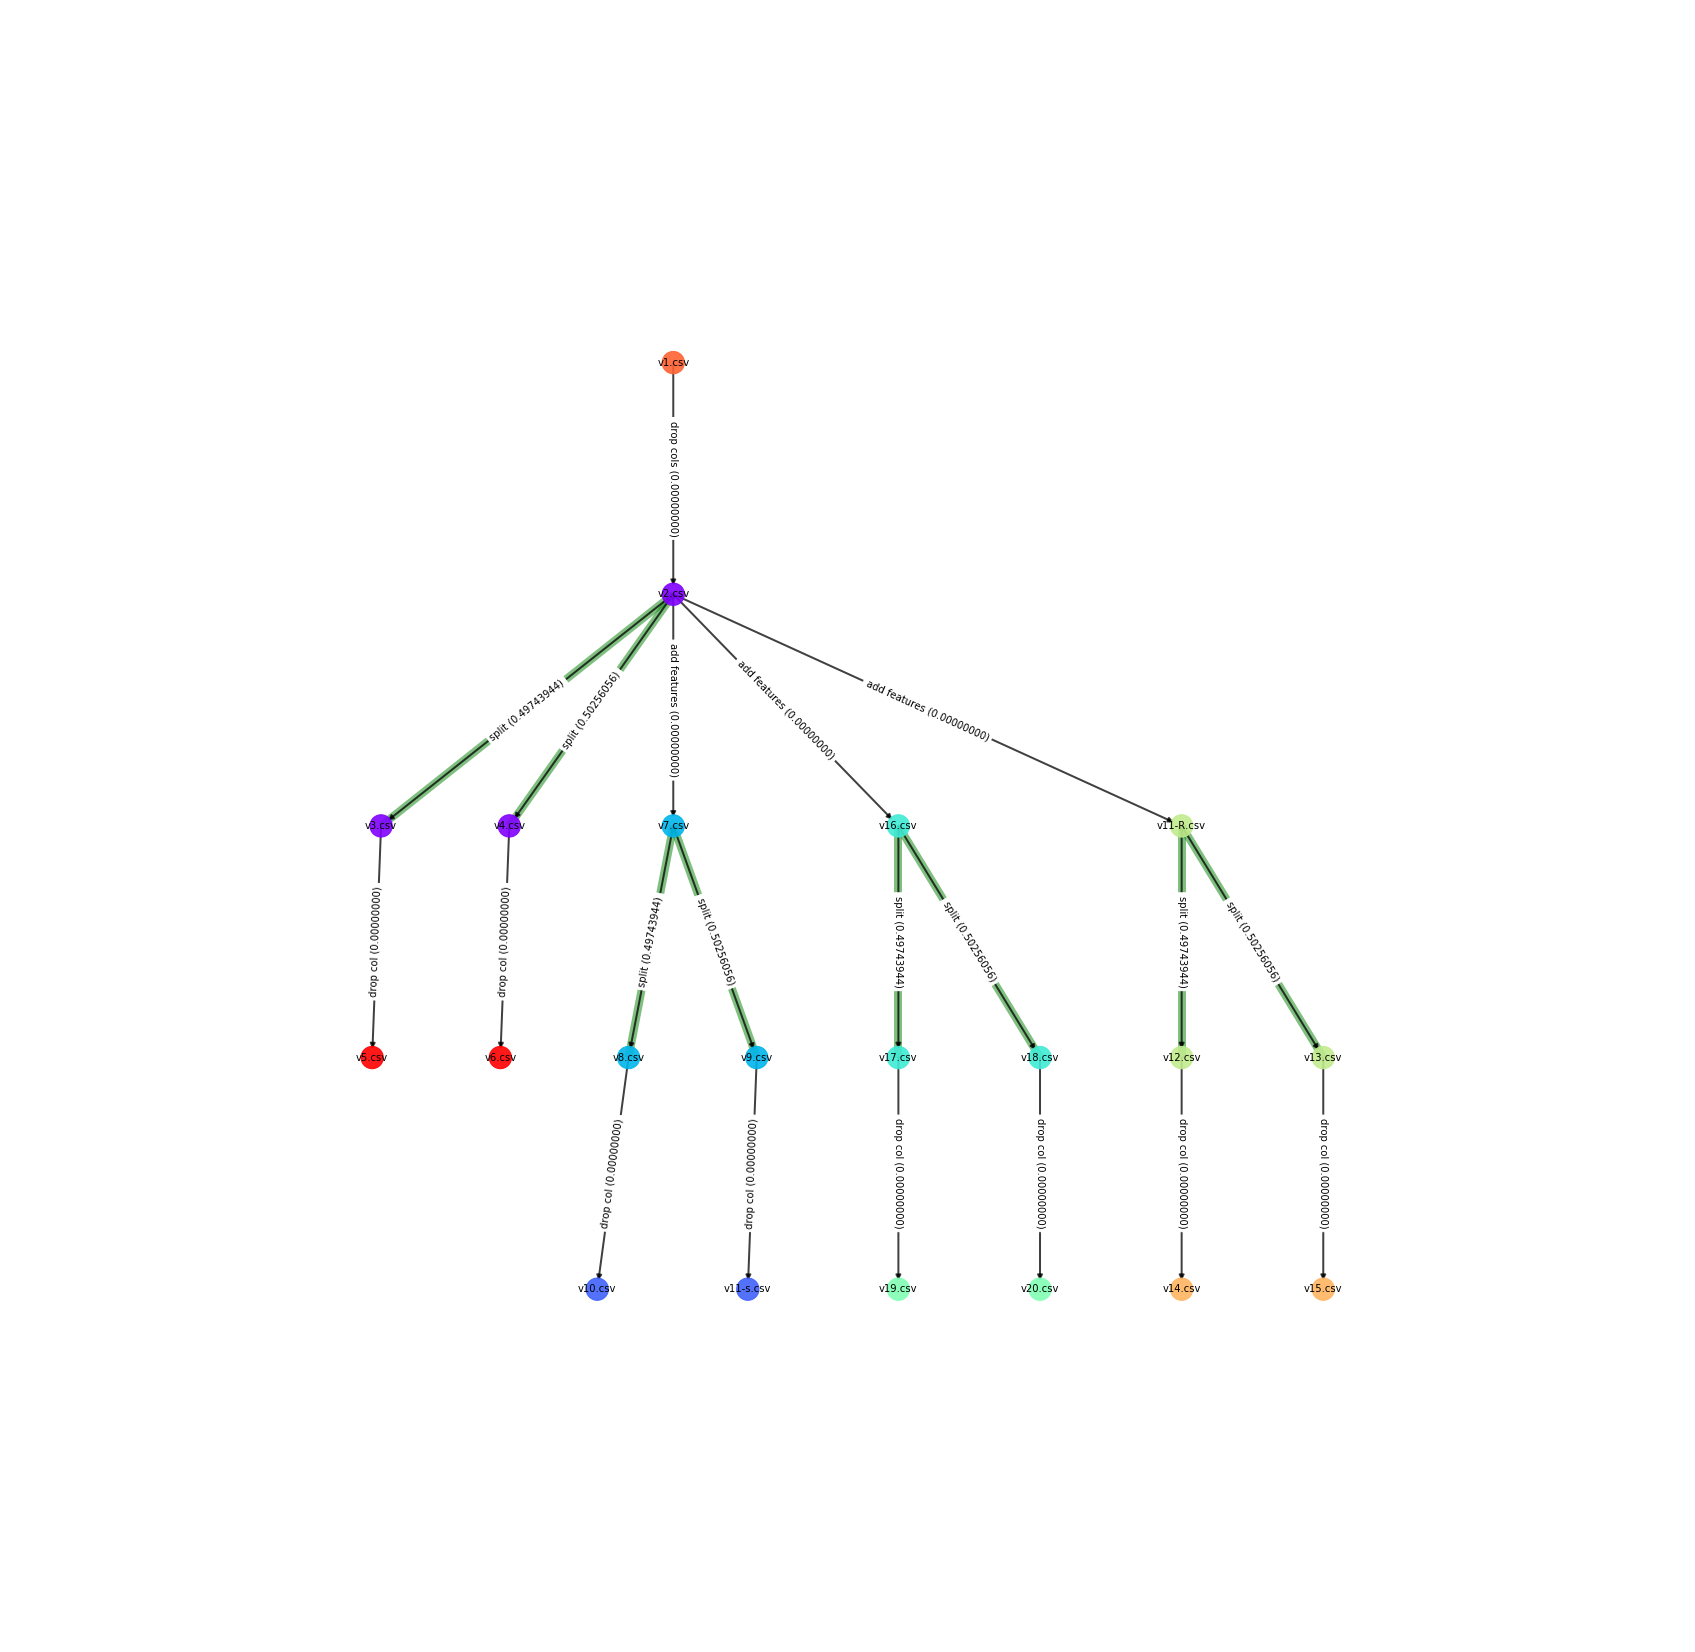

Num Clusters: 9


Adding Edge: v18.csv v20.csv 0.9795918367346939
None

v1.csv


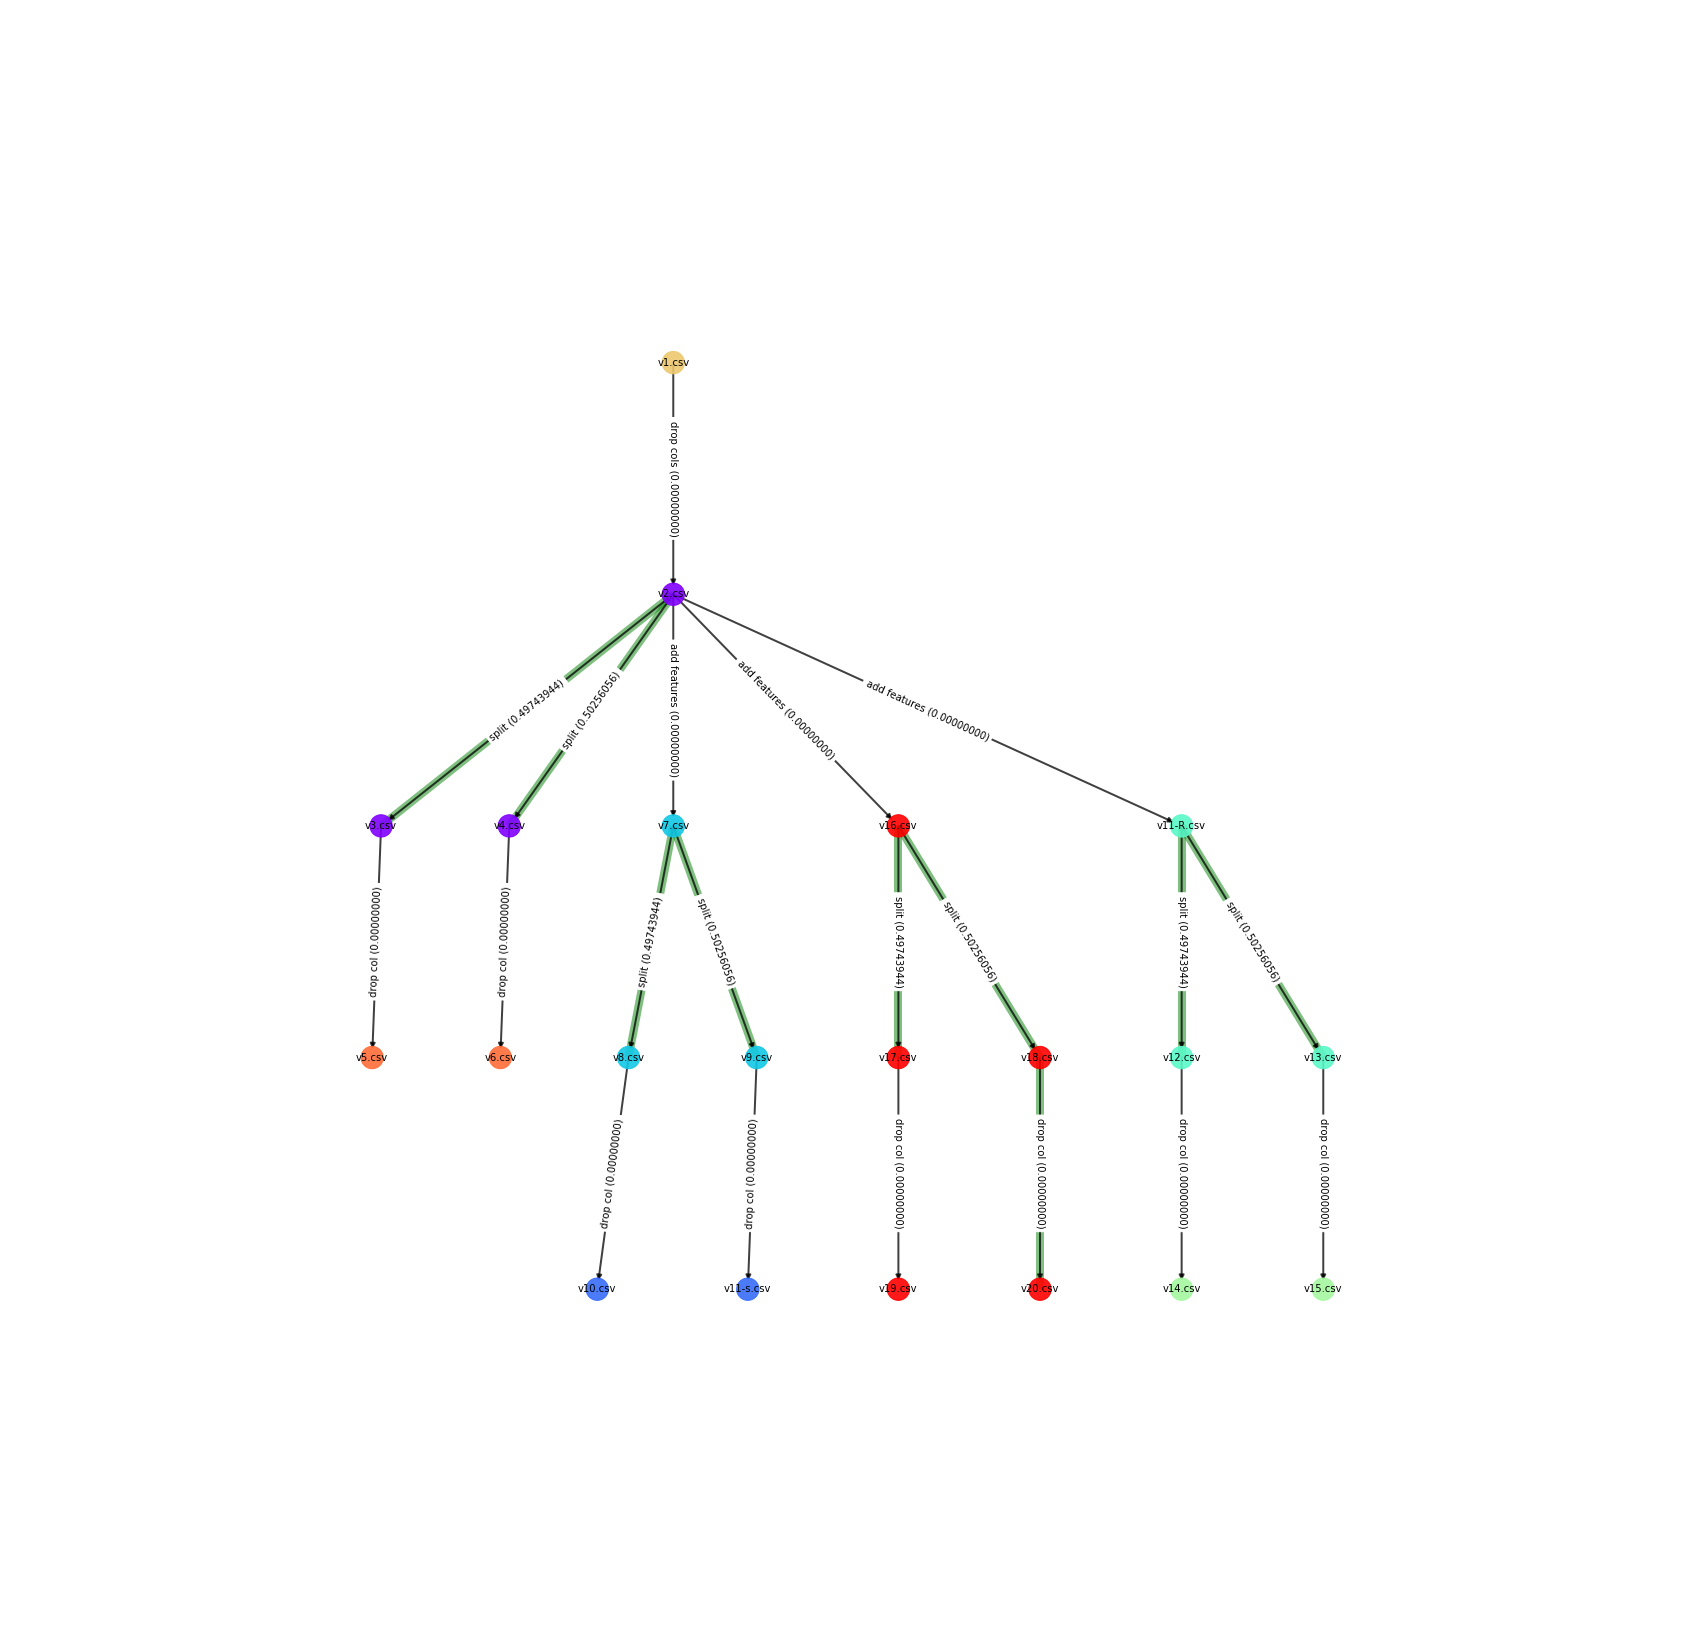

Num Clusters: 8


Adding Edge: v12.csv v14.csv 0.972972972972973
None

v1.csv


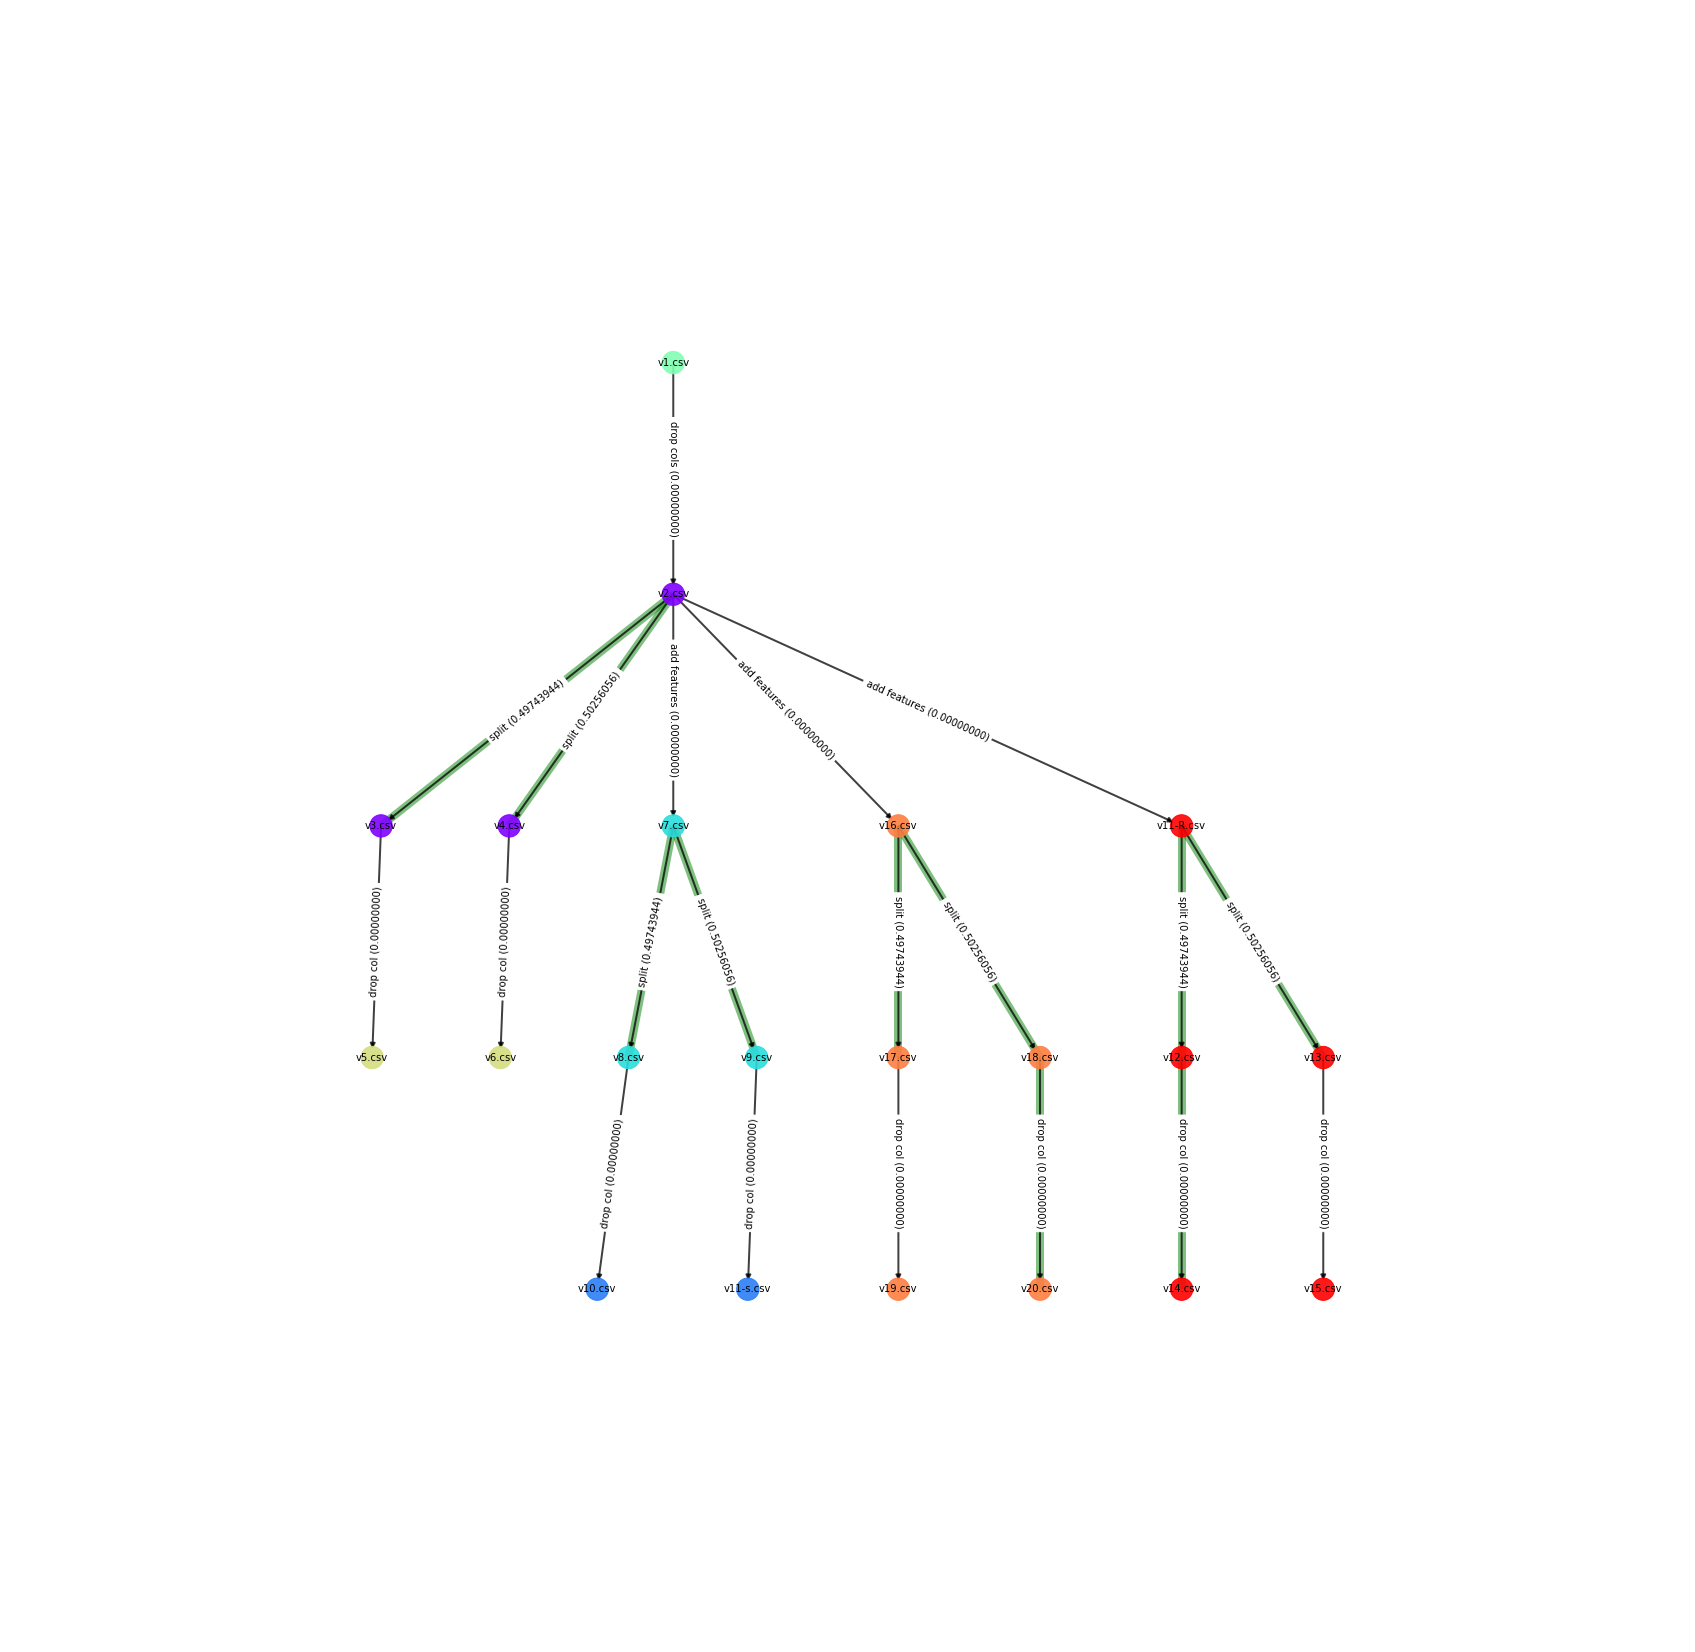

Num Clusters: 7


Adding Edge: v11-s.csv v9.csv 0.96
None

v1.csv


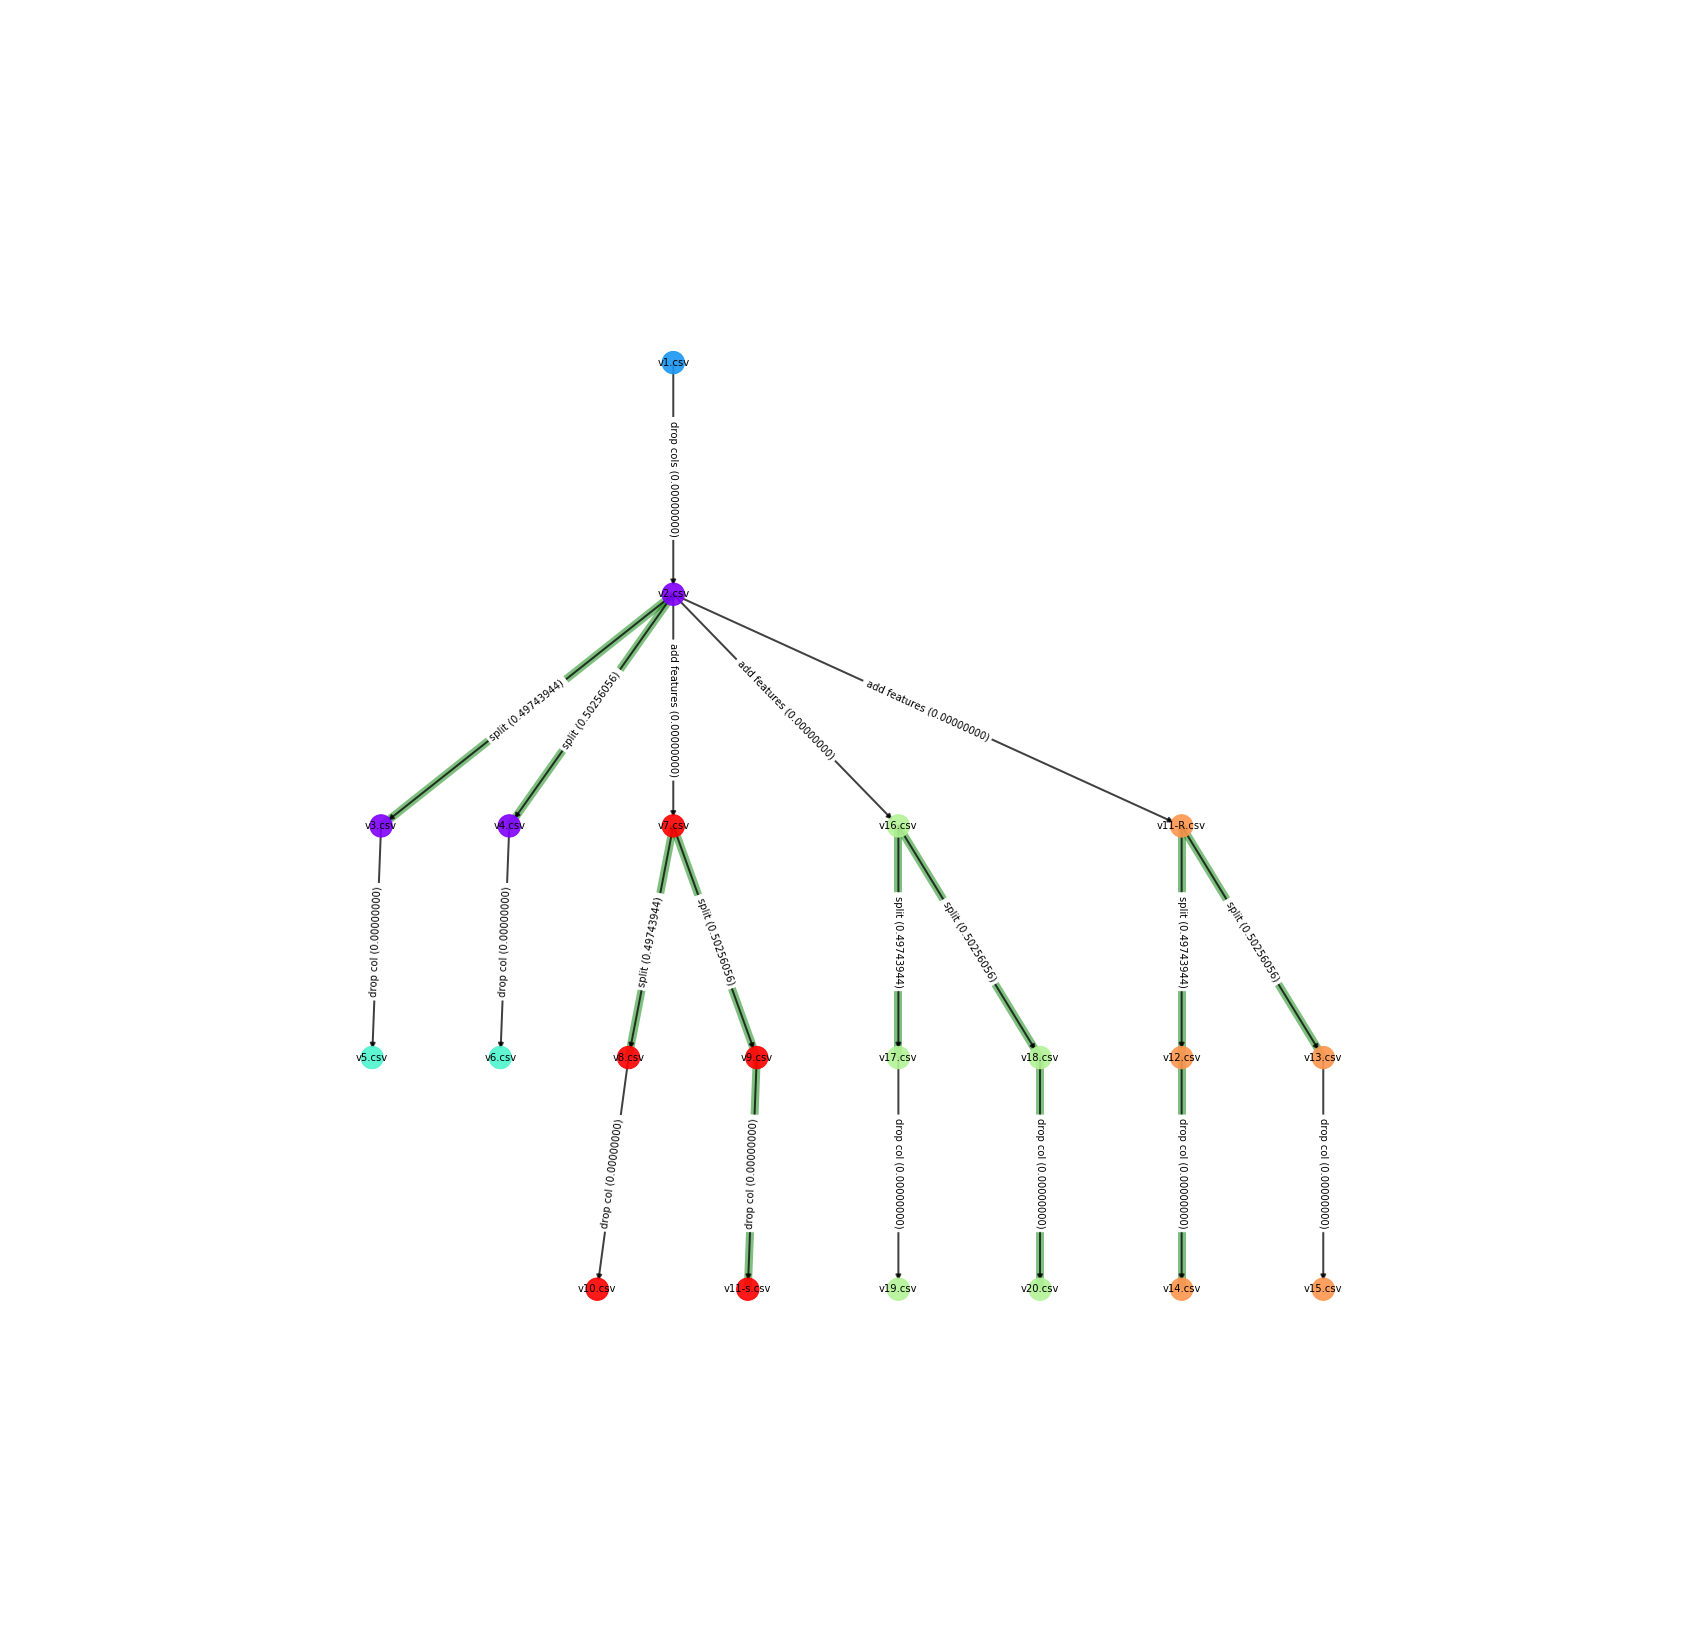

Num Clusters: 6


Adding Edge: v3.csv v5.csv 0.9230769230769231
None

v1.csv


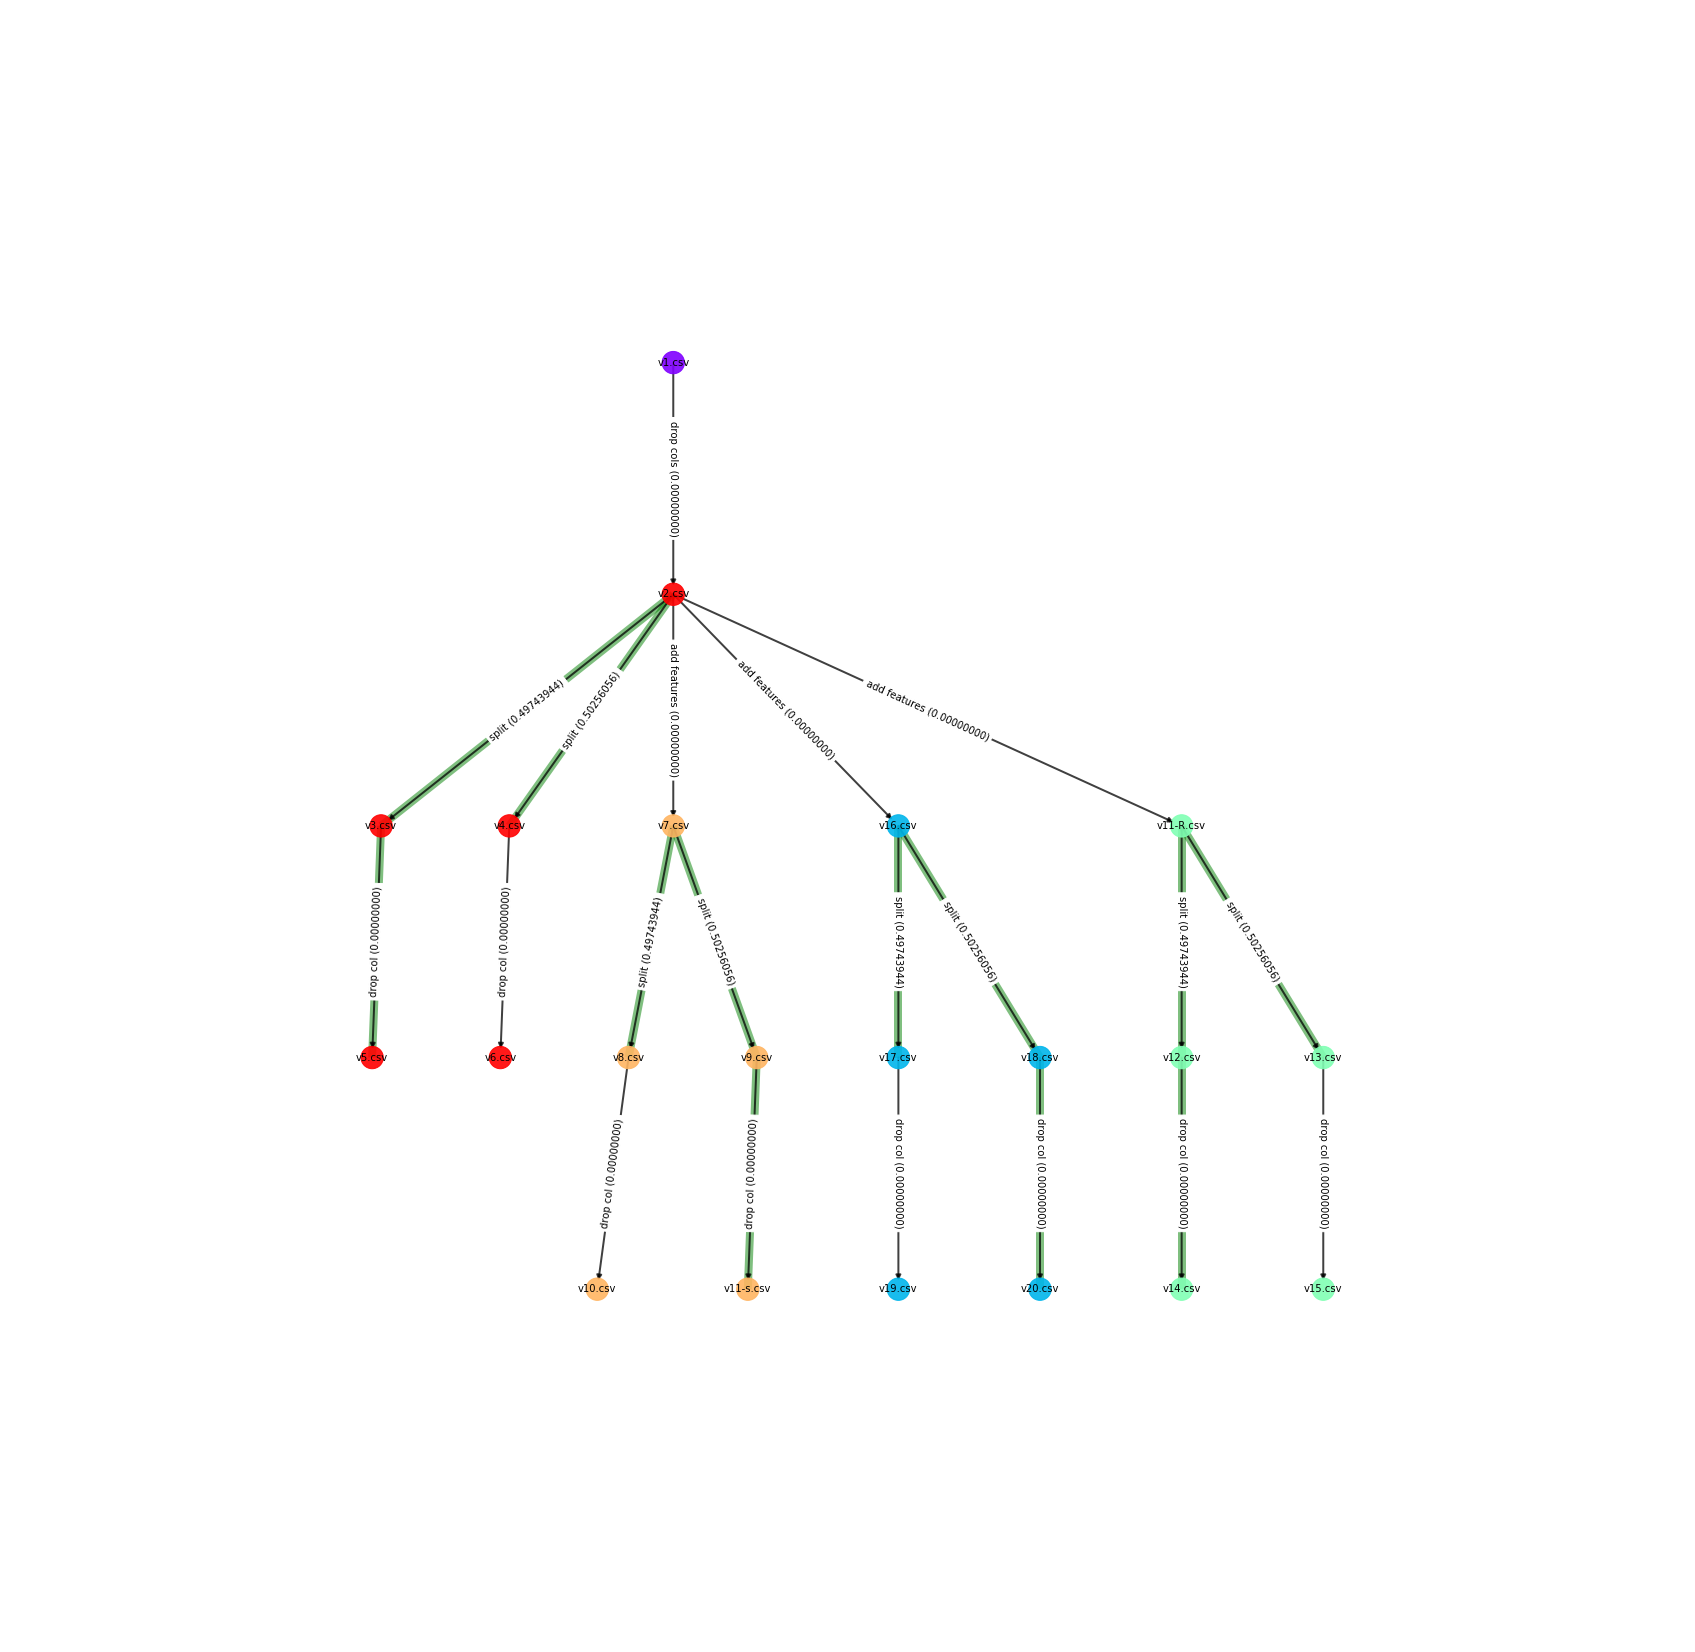

Num Clusters: 5


Adding Edge: v1.csv v2.csv 0.8125
None

v5.csv


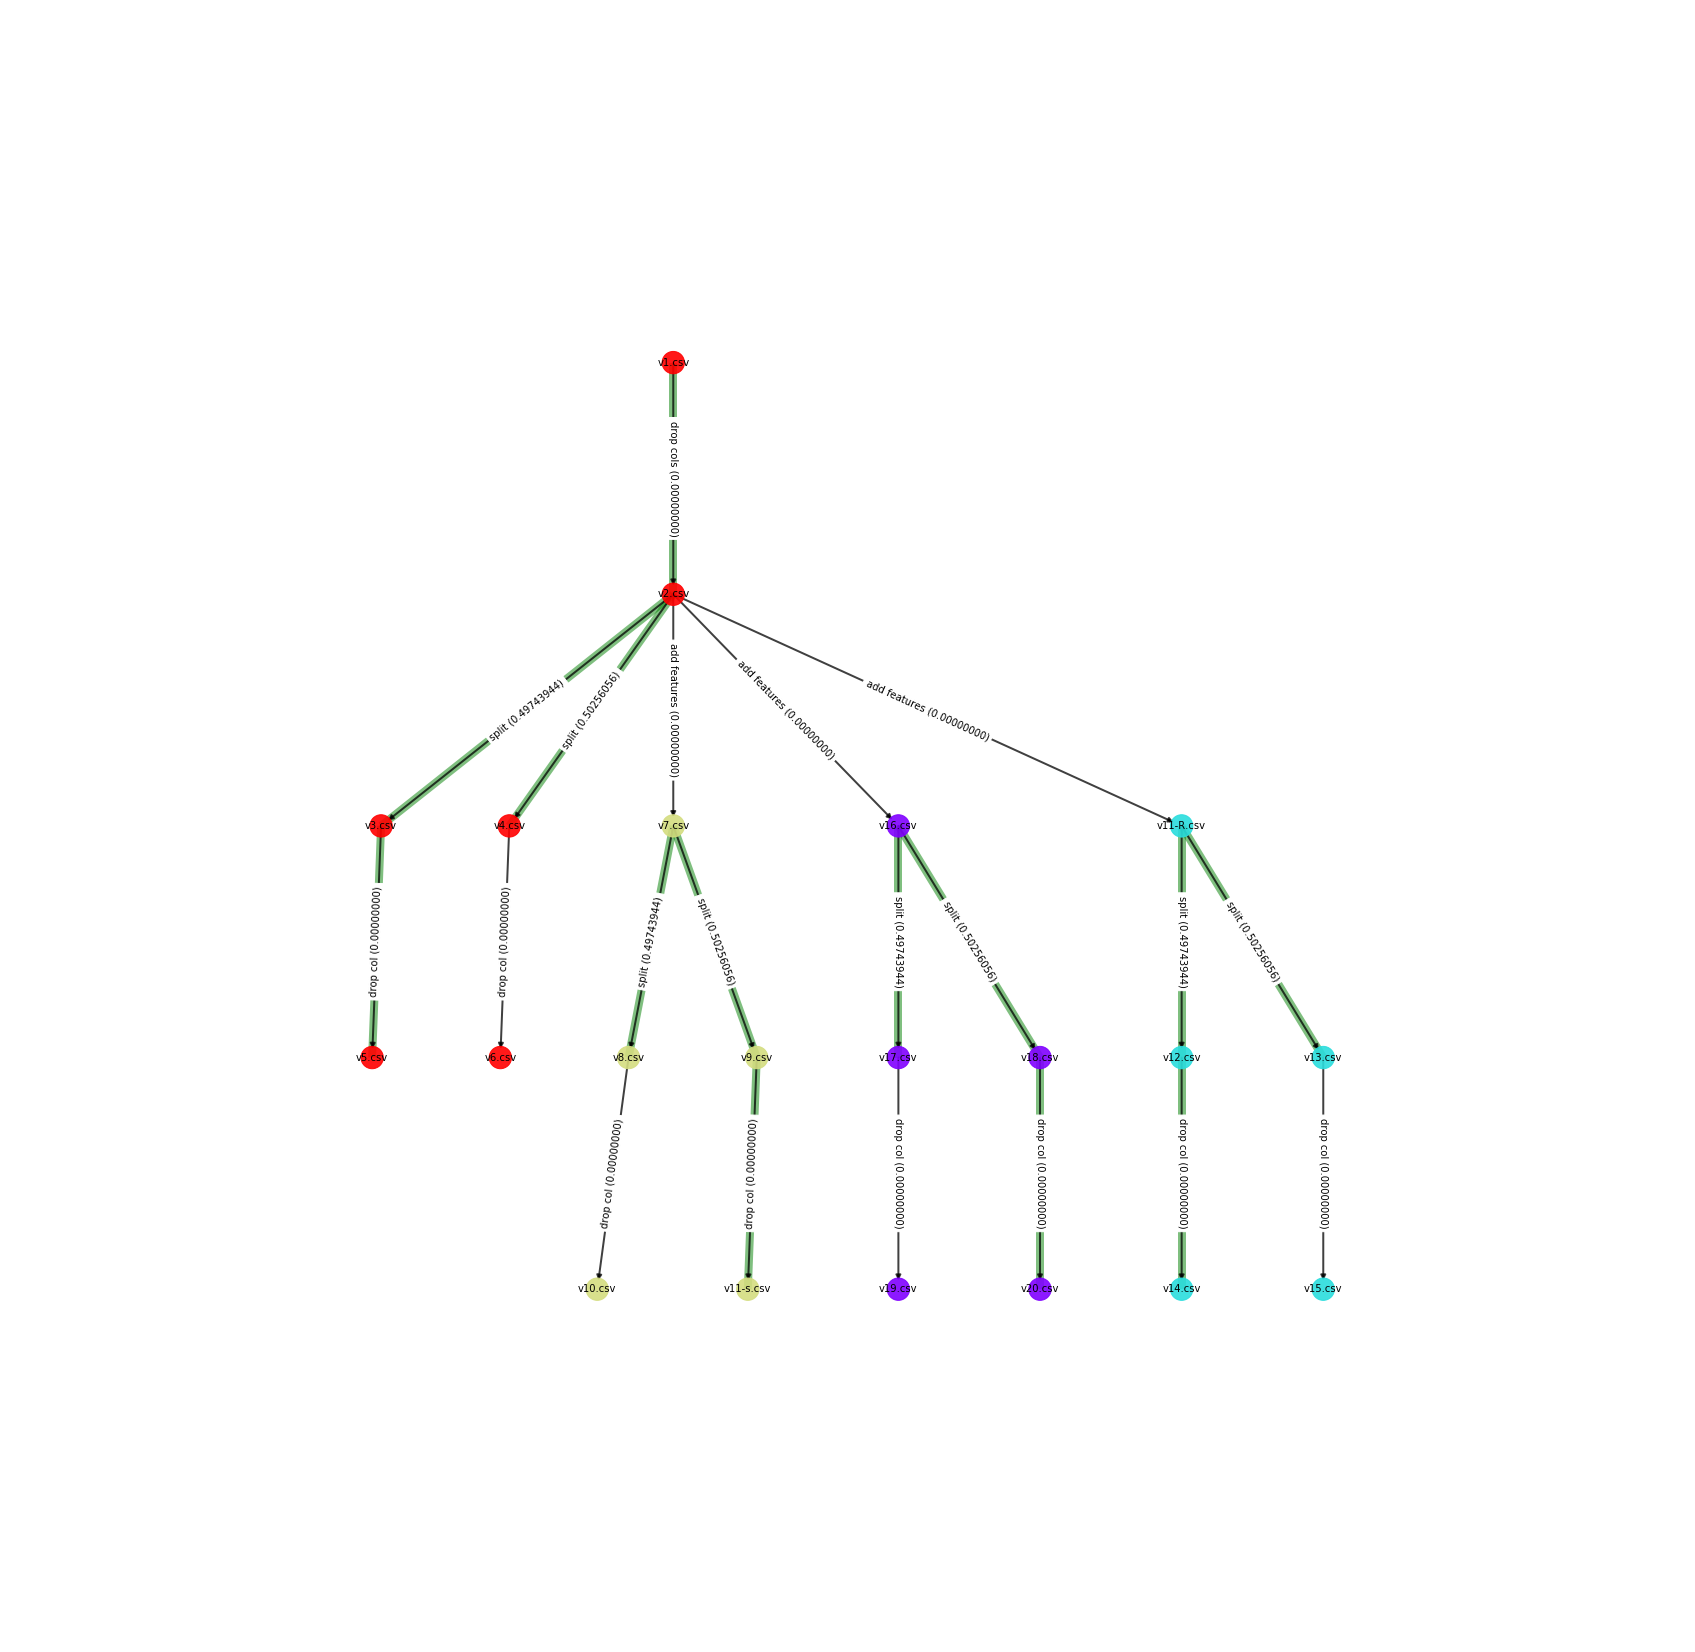

Num Clusters: 4


Adding Edge: v16.csv v11-R.csv 0.7551020408163265
None

v5.csv


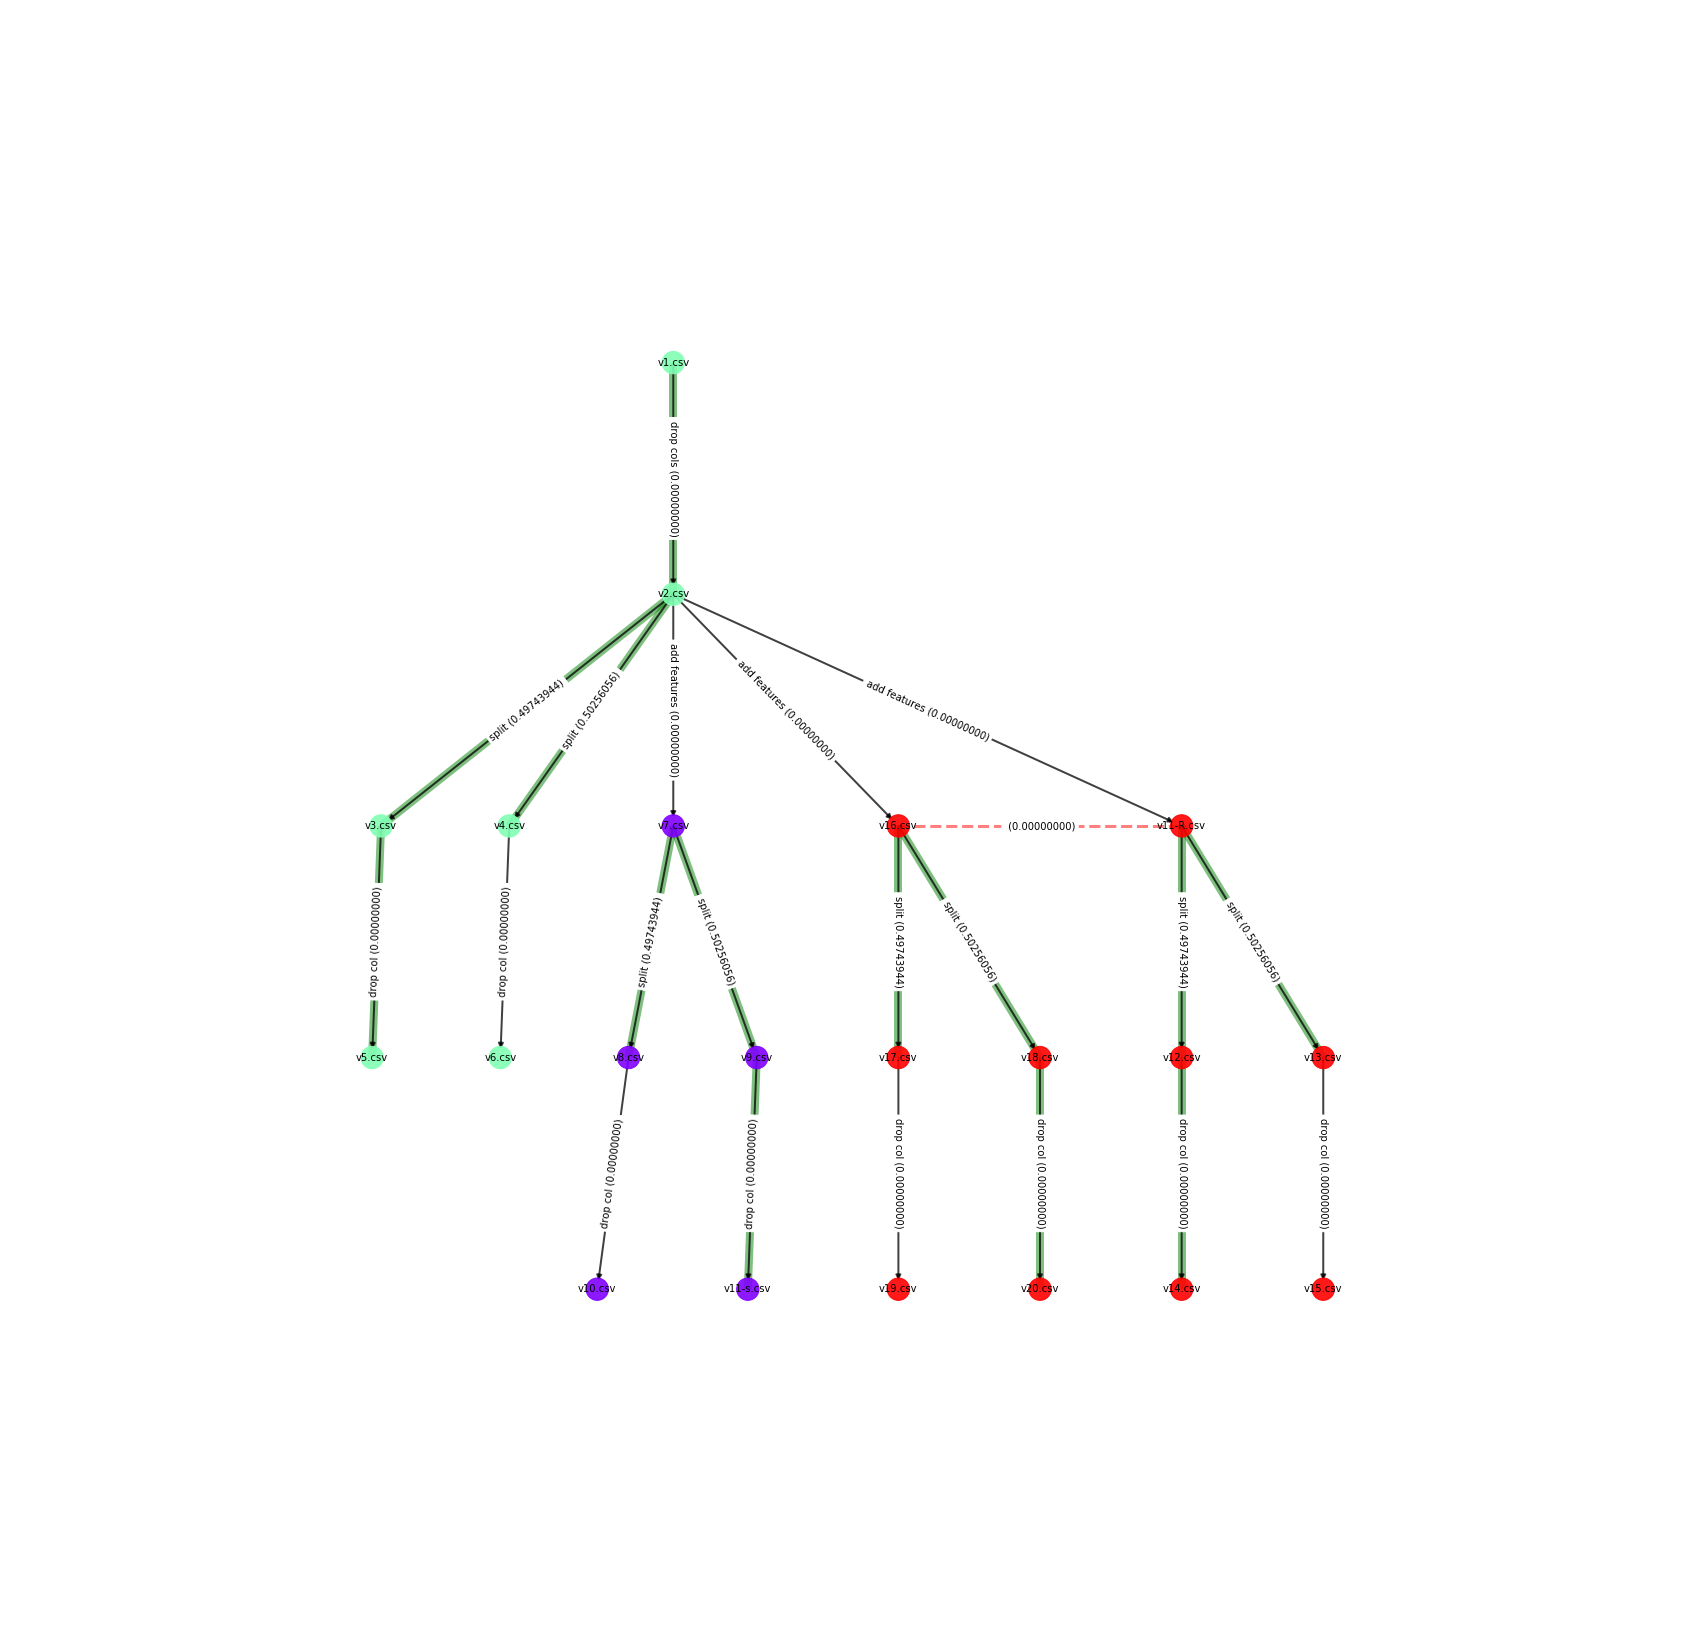

Num Clusters: 3


Adding Edge: v7.csv v11-R.csv 0.6756756756756757
None

v5.csv


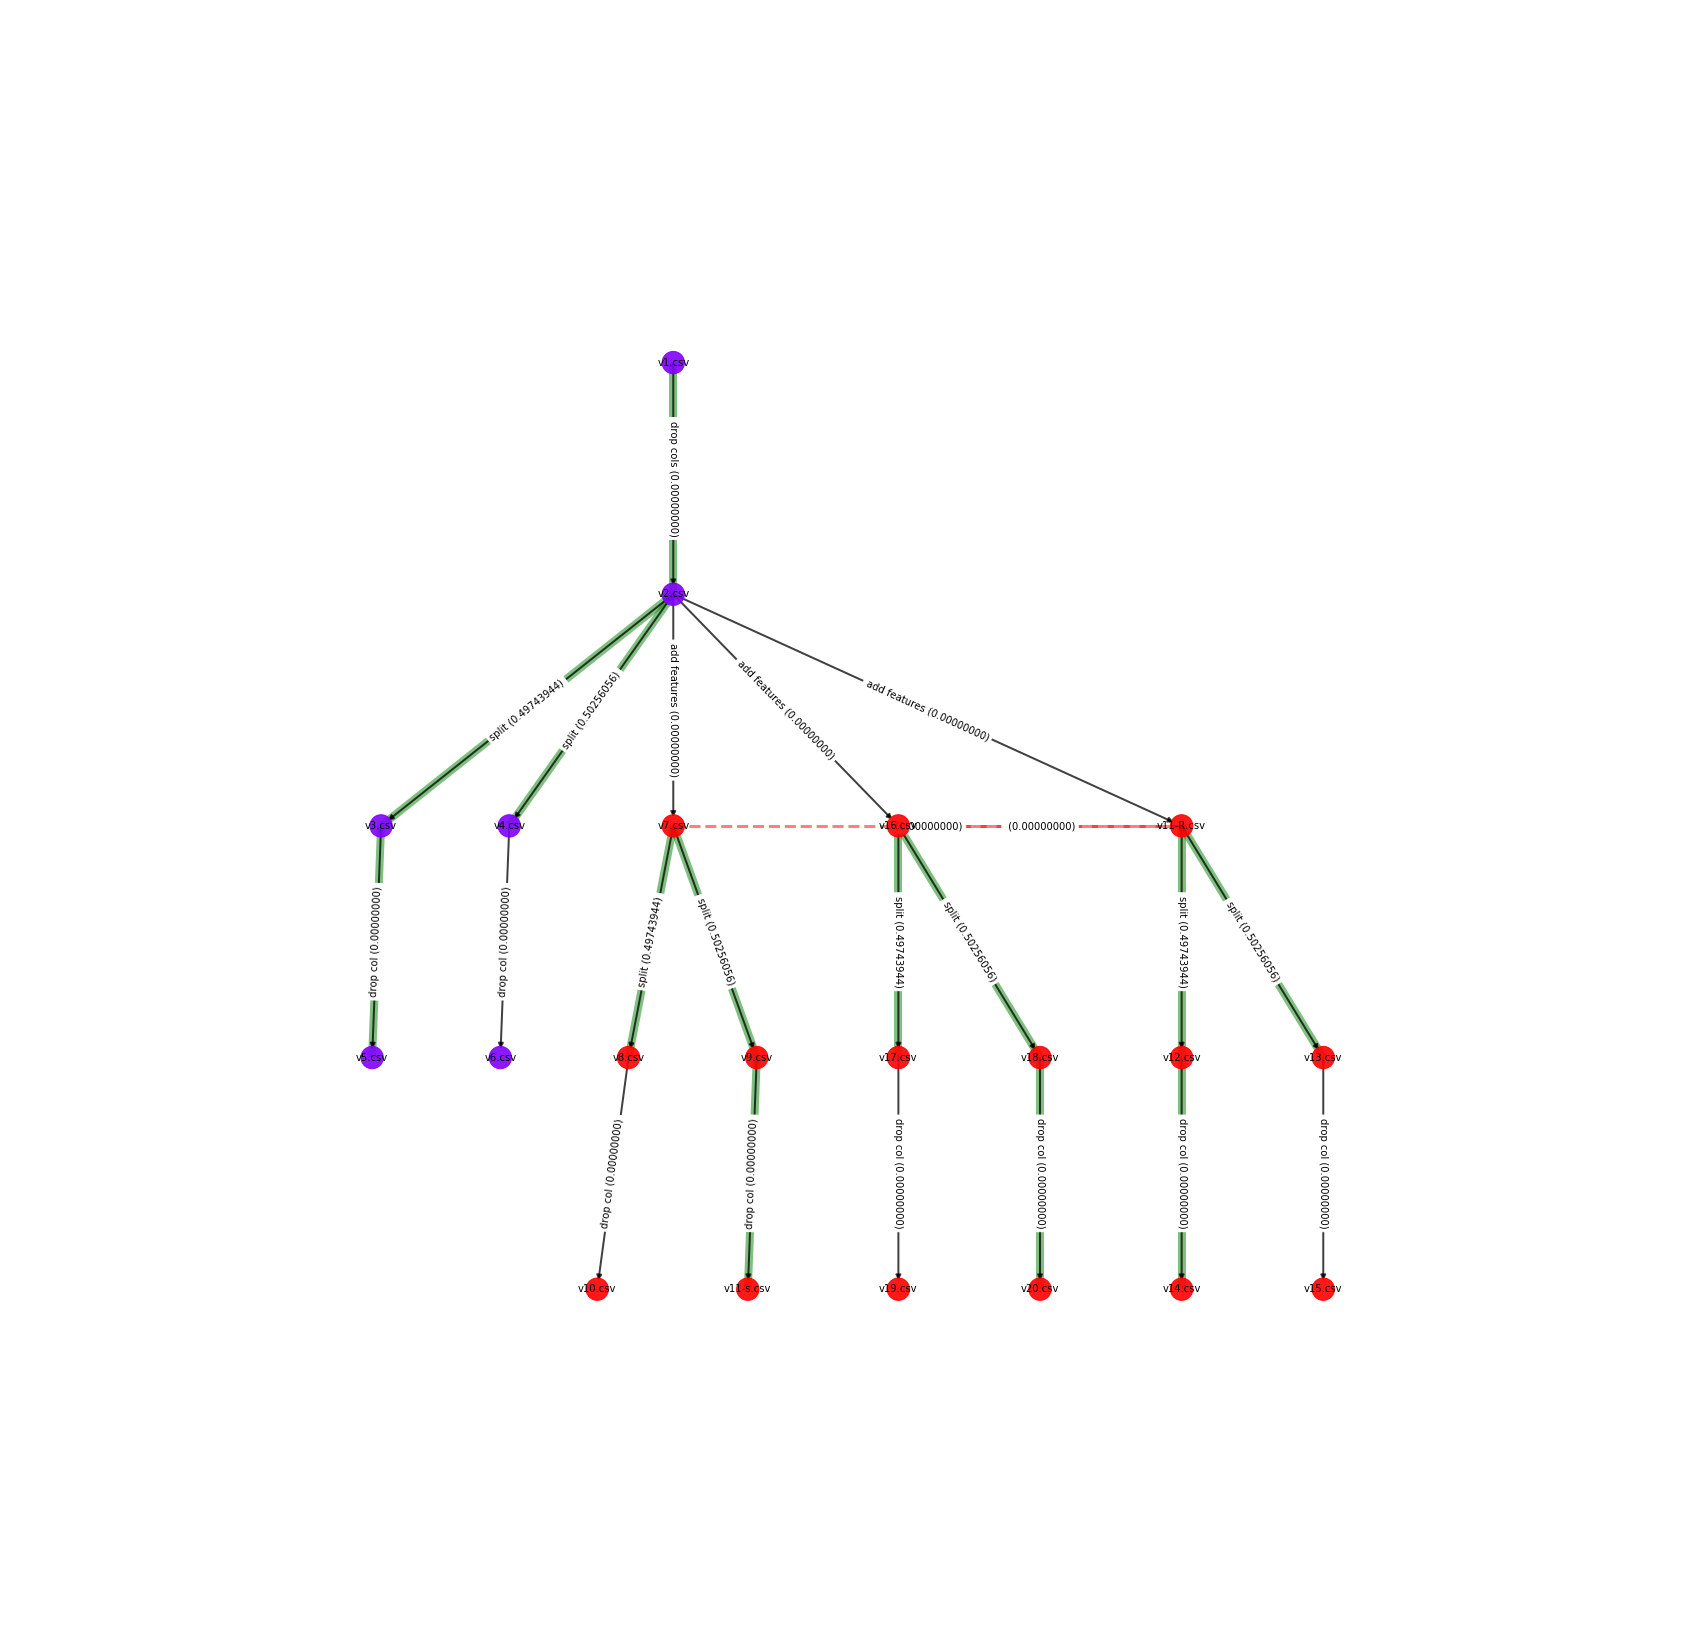

Num Clusters: 2


Adding Edge: v3.csv v8.csv 0.52
None

v5.csv


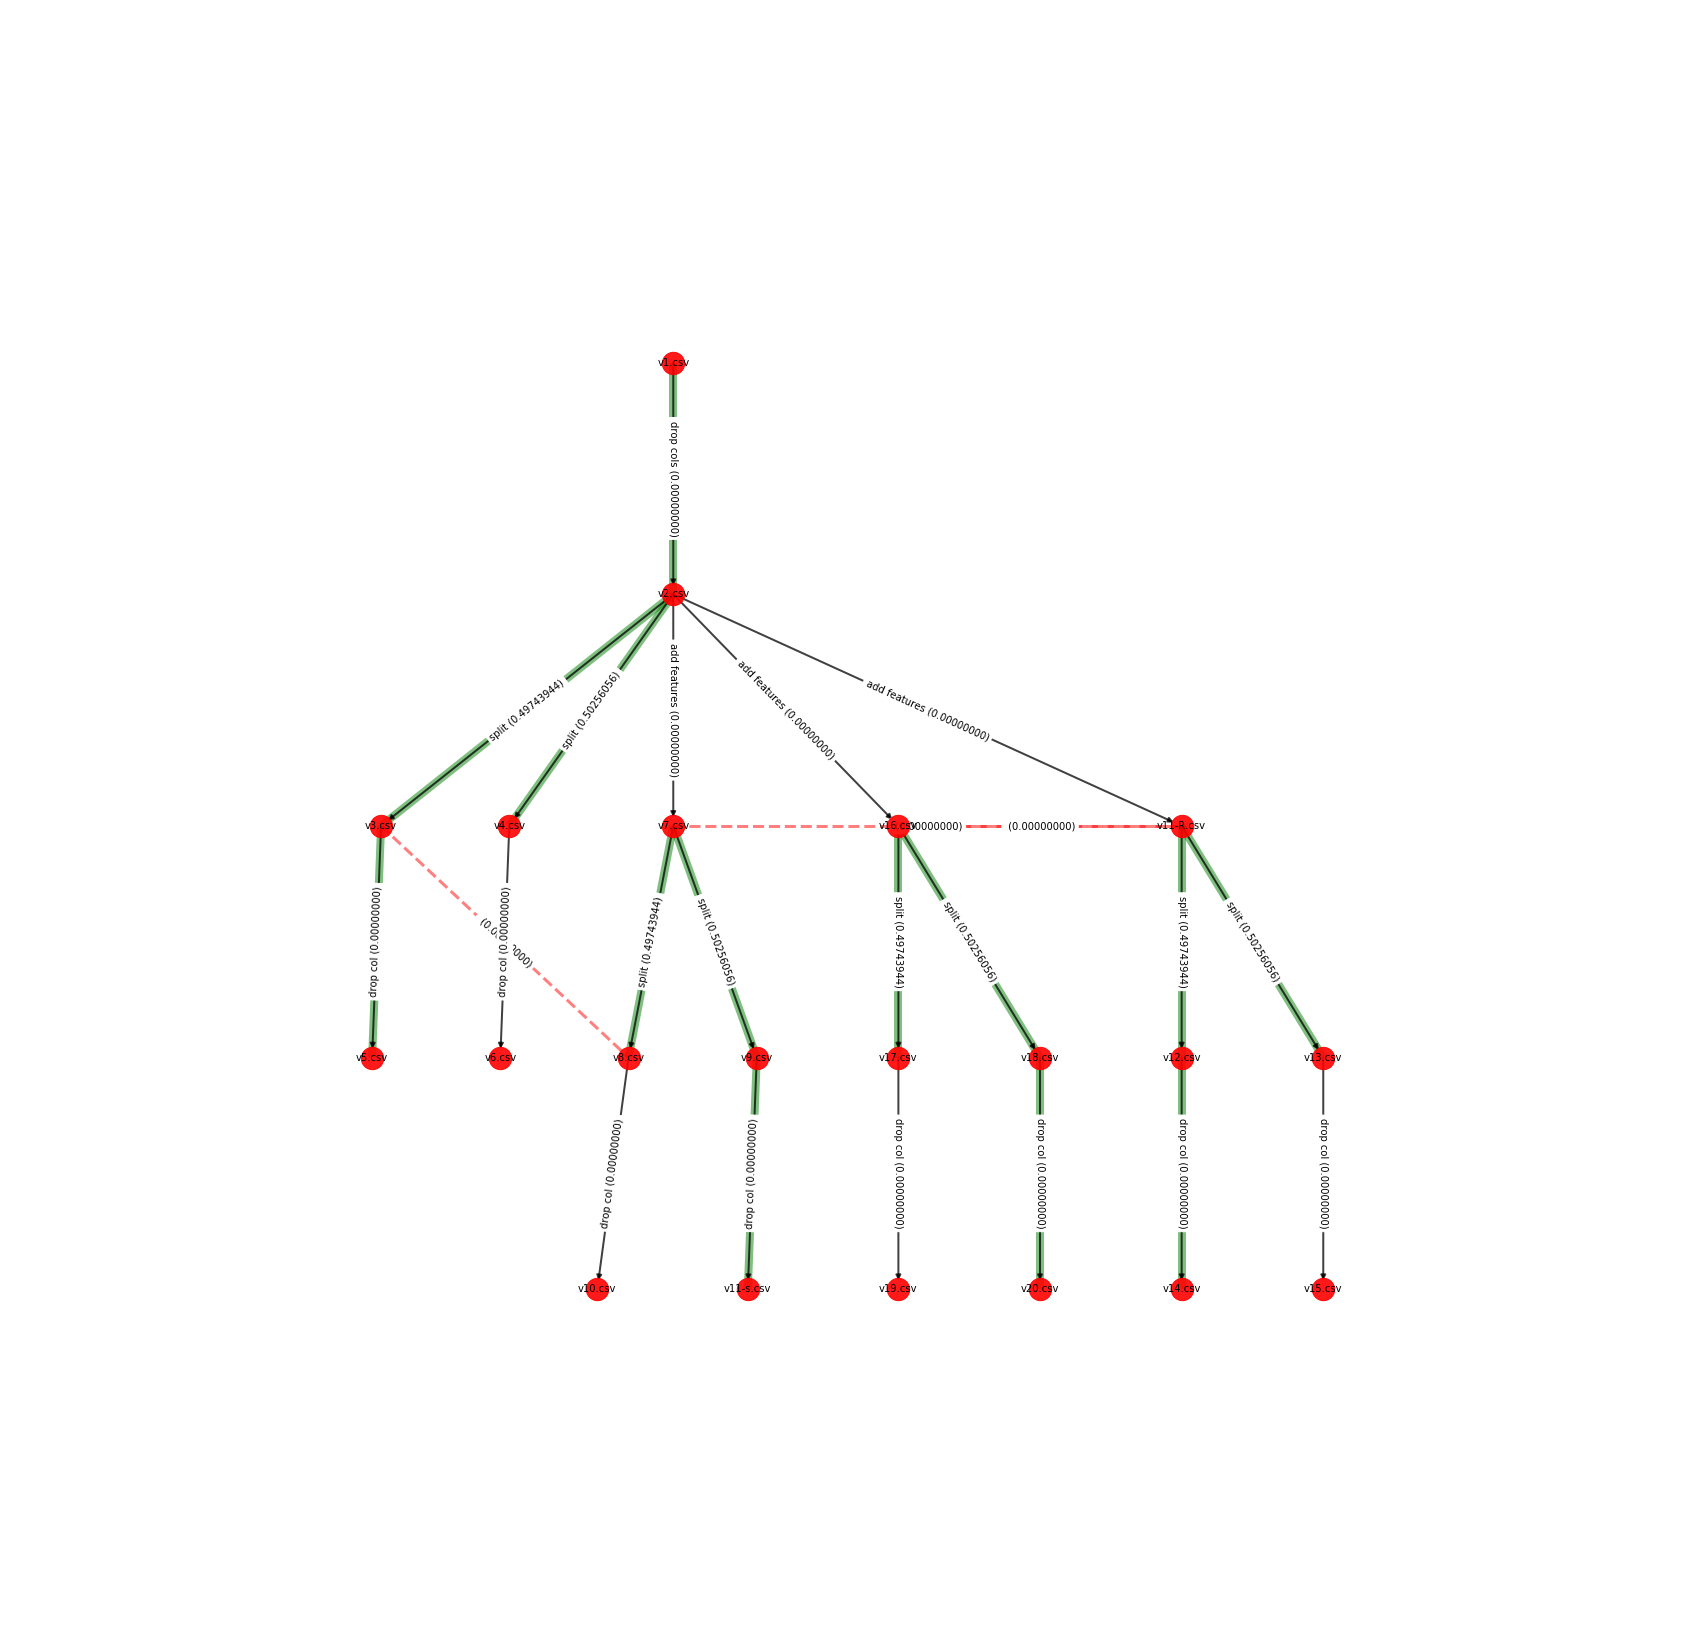

,nb_name,index,numclusters,distance_metric,edges_correct,edges_missing,edges_to_remove,join_edges,precision,recall,F1,missing_files
0,retail,True,9,pandas_cell,8,12,0,NaN,0.40,1.000000,0.571429,0
1,retail,True,8,pandas_cell,9,11,0,NaN,0.45,1.000000,0.620690,0
2,retail,True,7,pandas_cell,10,10,0,NaN,0.50,1.000000,0.666667,0
3,retail,True,6,pandas_cell,11,9,0,NaN,0.55,1.000000,0.709677,0
4,retail,True,5,pandas_cell,12,8,0,NaN,0.60,1.000000,0.750000,0
5,retail,True,4,pandas_cell,13,7,0,NaN,0.65,1.000000,0.787879,0
6,retail,True,3,pandas_cell,13,7,1,NaN,0.65,0.928571,0.764706,0
7,retail,True,2,pandas_cell,13,7,2,NaN,0.65,0.866667,0.742857,0
8,retail,True,1,pandas_cell,13,7,3,NaN,0.65,0.812500,0.722222,0


In [252]:
df = lineage_inference_agglomerative(nb_name=NB_NAME)
df

In [218]:
from PIL import Image

image_frames = [Image.open(frame) for frame in img_frames]

In [69]:
image_frames[0].save('mexican.gif', 
                     format='GIF', append_images=image_frames[1:], 
                     save_all=True,
                     duration=1000, 
                     loop=0)

In [219]:
df[['numclusters', 'edges_correct','edges_missing', 'edges_to_remove', 'F1']][:-1]


,numclusters,edges_correct,edges_missing,edges_to_remove,F1
0,9,8,12,0,0.571429
1,8,9,11,0,0.620690
2,7,10,10,0,0.666667
3,6,11,9,0,0.709677
4,5,12,8,0,0.750000
5,4,13,7,0,0.787879
6,3,13,7,1,0.764706
7,2,13,7,2,0.742857
8,1,13,7,3,0.722222


In [250]:
schema_dict

defaultdict(list,
            {frozenset({'atemp',
                        'casual',
                        'cnt',
                        'demand in day -1',
                        'demand in day -10',
                        'demand in day -11',
                        'demand in day -12',
                        'demand in day -2',
                        'demand in day -3',
                        'demand in day -4',
                        'demand in day -5',
                        'demand in day -6',
                        'demand in day -7',
                        'demand in day -8',
                        'demand in day -9',
                        'demand in hour -1',
                        'demand in hour -10',
                        'demand in hour -11',
                        'demand in hour -12',
                        'demand in hour -2',
                        'demand in hour -3',
                        'demand in hour -4',
                        'demand in 